# Import Required Libraries

In [ ]:
import os
import gc
import cv2
import math
import copy
import time
import random
import glob
from matplotlib import pyplot as plt

# For data manipulation
import numpy as np
import pandas as pd

# Pytorch Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.cuda import amp
import torchvision

# Utils
import joblib
from tqdm import tqdm
from collections import defaultdict

# Sklearn Imports
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold

# For Image Models
import timm

# Albumentations for augmentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

# For colored terminal text
from colorama import Fore, Back, Style
b_ = Fore.BLUE
sr_ = Style.RESET_ALL

import warnings
warnings.filterwarnings("ignore")

# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

# raining Configuration

In [ ]:
CONFIG = {
    "seed": 777,
    "epochs": 8,
    "img_size": 2048,
    "model_name": "tf_efficientnetv2_s_in21ft1k",
    "checkpoint_path" : "/content/drive/MyDrive/Colab Notebooks/UBC_OCEAN/tf_efficientnet_b0_aa-827b6e33.pth",
    "num_classes": 5,
    "train_batch_size": 2,
    "valid_batch_size": 4,
    "learning_rate": 1e-4,
    "scheduler": 'CosineAnnealingLR',
    "min_lr": 1e-6,
    "T_max": 500,
    "weight_decay": 1e-6,
    "fold" : 0,
    "n_fold": 5,
    "n_accumulate": 1,
    "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
}

# Set Seed for Reproducibility

In [ ]:
def set_seed(seed=42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(CONFIG['seed'])

In [ ]:
ROOT_DIR = ''
TRAIN_DIR = ''
TEST_DIR = ''

In [ ]:
def get_train_file_path(image_id):
    return f"{TRAIN_DIR}/{image_id}_thumbnail.png"

# Read the Data

In [ ]:
train_images = sorted(glob.glob(f"{TRAIN_DIR}/*.png"))

In [ ]:
df = pd.read_csv(f"{ROOT_DIR}/train.csv")
df['file_path'] = df['image_id'].apply(get_train_file_path)
df = df[ df["file_path"].isin(train_images) ].reset_index(drop=True)
df

,image_id,label,image_width,image_height,is_tma,file_path
0,4,HGSC,23785,20008,False,/content/drive/MyDrive/Colab Notebooks/UBC_OCE...
1,66,LGSC,48871,48195,False,/content/drive/MyDrive/Colab Notebooks/UBC_OCE...
2,281,LGSC,42309,15545,False,/content/drive/MyDrive/Colab Notebooks/UBC_OCE...
3,286,EC,37204,30020,False,/content/drive/MyDrive/Colab Notebooks/UBC_OCE...
4,431,HGSC,39991,40943,False,/content/drive/MyDrive/Colab Notebooks/UBC_OCE...
...,...,...,...,...,...,...
508,65022,LGSC,53355,46675,False,/content/drive/MyDrive/Colab Notebooks/UBC_OCE...
509,65094,MC,55042,45080,False,/content/drive/MyDrive/Colab Notebooks/UBC_OCE...
510,65300,HGSC,75860,27503,False,/content/drive/MyDrive/Colab Notebooks/UBC_OCE...
511,65371,HGSC,42551,41800,False,/content/drive/MyDrive/Colab Notebooks/UBC_OCE...


In [ ]:
df.loc[df["image_id"] == 15583, "label"] = "MC"
df[df["image_id"] == 15583]

,image_id,label,image_width,image_height,is_tma,file_path
126,15583,MC,32821,23837,False,/content/drive/MyDrive/Colab Notebooks/UBC_OCE...


In [ ]:
CONFIG['T_max'] = df.shape[0] * (CONFIG["n_fold"]-1) * CONFIG['epochs'] // CONFIG['train_batch_size'] // CONFIG["n_fold"]
CONFIG['T_max']

1641

In [ ]:
# トリミング画像の取得
from PIL import Image

def get_cropped_images(file_path, image_id, label_,th_area=1000):
    image = Image.open(file_path)

    as_ratio = image.size[0] / image.size[1]

    sxs, exs, sys, eys = [], [], [], []

    if as_ratio >= 1.5:
        # アスペクト比が1.5>=の時（横長の時にトリミング）

        #非0のピクセルのマスクの作製
        mask = np.max(np.array(image) > 0, axis=-1).astype(np.uint8)

        # マスクから結合の要素を抽出（連結成分は、隣接する非ゼロのピクセルが同じラベルでマークされた領域）
        retval, labels = cv2.connectedComponents(mask)

        if retval >= as_ratio:
           #連結部分がアスペクト比以上の時、境界ボックスを計算
            x, y = np.meshgrid(np.arange(image.size[0]), np.arange(image.size[1]))
            for label in range(1, retval):
               #連結部分の面積の計算
                area = np.sum(labels == label)
                #面積がth_area未満の場合にはスキップ
                if area < th_area:
                    continue

                #連結部分の座標の取得
                xs, ys = x[labels == label], y[labels == label]

                #連結部分のx座標の最小値と最大値の取得
                sx, ex = np.min(xs), np.max(xs)
                #中心座標
                cx = (sx + ex) // 2
                #トリミング領域のサイズ
                crop_size = image.size[1]
                #トリミング領域開始x座標
                sx = max(0, cx - crop_size // 2)
                #トリミング領域終了x座標
                ex = min(sx + crop_size - 1, image.size[0] - 1)
                #トリミング領域開始x座標再調整
                sx = ex - crop_size + 1
                #トリミング領域y座標
                sy, ey = 0, image.size[1] - 1

                # リストに座標を追加
                sxs.append(sx)
                exs.append(ex)
                sys.append(sy)
                eys.append(ey)
        else:
            #連結部分がない場合、等分割する
            crop_size = image.size[1]
            for i in range(int(as_ratio)):
                sxs.append(i * crop_size)
                exs.append((i + 1) * crop_size - 1)
                sys.append(0)
                eys.append(crop_size - 1)
    else:
        # アスペクト比が1.5未満の時、トリミング領域をしない
        sxs, exs, sys, eys = [0,], [image.size[0] - 1], [0,], [image.size[1] - 1]

    # df_cropに画像データ、パス、座標を追加
    df_crop = pd.DataFrame()
    df_crop["image_id"] = [image_id] * len(sxs)
    df_crop["file_path"] = [file_path] * len(sxs)
    df_crop["sx"] = sxs
    df_crop["ex"] = exs
    df_crop["sy"] = sys
    df_crop["ey"] = eys
    df_crop["label"] = [label_] * len(sxs)

    return df_crop

dfs = []

for (file_path, image_id,label) in zip(df["file_path"], df["image_id"],df["label"]):
    dfs.append(get_cropped_images(file_path, image_id,label))

df_crop = pd.concat(dfs)

df_crop = df_crop.drop_duplicates(subset=["image_id", "sx", "ex", "sy", "ey"]).reset_index(drop=True)

In [ ]:
df

,image_id,label,image_width,image_height,is_tma,file_path
0,4,HGSC,23785,20008,False,/content/drive/MyDrive/Colab Notebooks/UBC_OCE...
1,66,LGSC,48871,48195,False,/content/drive/MyDrive/Colab Notebooks/UBC_OCE...
2,281,LGSC,42309,15545,False,/content/drive/MyDrive/Colab Notebooks/UBC_OCE...
3,286,EC,37204,30020,False,/content/drive/MyDrive/Colab Notebooks/UBC_OCE...
4,431,HGSC,39991,40943,False,/content/drive/MyDrive/Colab Notebooks/UBC_OCE...
...,...,...,...,...,...,...
508,65022,LGSC,53355,46675,False,/content/drive/MyDrive/Colab Notebooks/UBC_OCE...
509,65094,MC,55042,45080,False,/content/drive/MyDrive/Colab Notebooks/UBC_OCE...
510,65300,HGSC,75860,27503,False,/content/drive/MyDrive/Colab Notebooks/UBC_OCE...
511,65371,HGSC,42551,41800,False,/content/drive/MyDrive/Colab Notebooks/UBC_OCE...


In [ ]:
df_crop

,image_id,file_path,sx,ex,sy,ey,label
0,4,/content/drive/MyDrive/Colab Notebooks/UBC_OCE...,0,2999,0,2522,HGSC
1,66,/content/drive/MyDrive/Colab Notebooks/UBC_OCE...,0,2999,0,2957,LGSC
2,281,/content/drive/MyDrive/Colab Notebooks/UBC_OCE...,0,1101,0,1101,LGSC
3,281,/content/drive/MyDrive/Colab Notebooks/UBC_OCE...,1898,2999,0,1101,LGSC
4,286,/content/drive/MyDrive/Colab Notebooks/UBC_OCE...,0,2999,0,2419,EC
...,...,...,...,...,...,...,...
748,65094,/content/drive/MyDrive/Colab Notebooks/UBC_OCE...,0,2999,0,2456,MC
749,65300,/content/drive/MyDrive/Colab Notebooks/UBC_OCE...,43,1129,0,1086,HGSC
750,65300,/content/drive/MyDrive/Colab Notebooks/UBC_OCE...,1890,2976,0,1086,HGSC
751,65371,/content/drive/MyDrive/Colab Notebooks/UBC_OCE...,0,2999,0,2946,HGSC


In [ ]:
encoder = LabelEncoder()
df_crop['label'] = encoder.fit_transform(df_crop['label'])

with open("label_encoder.pkl", "wb") as fp:
    joblib.dump(encoder, fp)

In [ ]:
df_crop

,image_id,file_path,sx,ex,sy,ey,label
0,4,/content/drive/MyDrive/Colab Notebooks/UBC_OCE...,0,2999,0,2522,2
1,66,/content/drive/MyDrive/Colab Notebooks/UBC_OCE...,0,2999,0,2957,3
2,281,/content/drive/MyDrive/Colab Notebooks/UBC_OCE...,0,1101,0,1101,3
3,281,/content/drive/MyDrive/Colab Notebooks/UBC_OCE...,1898,2999,0,1101,3
4,286,/content/drive/MyDrive/Colab Notebooks/UBC_OCE...,0,2999,0,2419,1
...,...,...,...,...,...,...,...
748,65094,/content/drive/MyDrive/Colab Notebooks/UBC_OCE...,0,2999,0,2456,4
749,65300,/content/drive/MyDrive/Colab Notebooks/UBC_OCE...,43,1129,0,1086,2
750,65300,/content/drive/MyDrive/Colab Notebooks/UBC_OCE...,1890,2976,0,1086,2
751,65371,/content/drive/MyDrive/Colab Notebooks/UBC_OCE...,0,2999,0,2946,2


# Create Folds

In [ ]:
skf = StratifiedKFold(n_splits=CONFIG['n_fold'])

for fold, ( _, val_) in enumerate(skf.split(X=df_crop, y=df_crop.label)):
      df_crop.loc[val_ , "kfold"] = int(fold)

In [ ]:
df

,image_id,label,image_width,image_height,is_tma,file_path
0,4,HGSC,23785,20008,False,/content/drive/MyDrive/Colab Notebooks/UBC_OCE...
1,66,LGSC,48871,48195,False,/content/drive/MyDrive/Colab Notebooks/UBC_OCE...
2,281,LGSC,42309,15545,False,/content/drive/MyDrive/Colab Notebooks/UBC_OCE...
3,286,EC,37204,30020,False,/content/drive/MyDrive/Colab Notebooks/UBC_OCE...
4,431,HGSC,39991,40943,False,/content/drive/MyDrive/Colab Notebooks/UBC_OCE...
...,...,...,...,...,...,...
508,65022,LGSC,53355,46675,False,/content/drive/MyDrive/Colab Notebooks/UBC_OCE...
509,65094,MC,55042,45080,False,/content/drive/MyDrive/Colab Notebooks/UBC_OCE...
510,65300,HGSC,75860,27503,False,/content/drive/MyDrive/Colab Notebooks/UBC_OCE...
511,65371,HGSC,42551,41800,False,/content/drive/MyDrive/Colab Notebooks/UBC_OCE...


# Dataset Class</h1></span>

In [ ]:
class UBCDataset(Dataset):
    def __init__(self, df, transforms=None):
        self.df = df
        self.file_names = df['file_path'].values
        self.labels = df['label'].values
        self.transforms = transforms
        self.sxs = df["sx"].values
        self.exs = df["ex"].values
        self.sys = df["sy"].values
        self.eys = df["ey"].values

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        img_path = self.file_names[index]
        sx, ex, sy, ey = self.sxs[index], self.exs[index], self.sys[index], self.eys[index]

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img[sy:ey, sx:ex, :]
        label = self.labels[index]

        if self.transforms:
            img = self.transforms(image=img)["image"]

        return {
            'image': img,
            'label': torch.tensor(label, dtype=torch.long)
        }

# Augmentations

    Resize: 画像のサイズを指定されたサイズに変更します。
    ShiftScaleRotate: 画像をランダムに平行移動、スケーリング、回転させます。
    HueSaturationValue: 色相、彩度、明度をランダムに変更します。
    RandomBrightnessContrast: ランダムに明るさとコントラストを変更します。
    Normalize: 画像の正規化を行います。平均、標準偏差、および最大ピクセル値が指定されています。
    ToTensorV2: 画像をPyTorchテンソルに変換します。

In [ ]:
data_transforms = {
    "train": A.Compose([
        A.Resize(CONFIG['img_size'], CONFIG['img_size']),
        A.ShiftScaleRotate(shift_limit=0.1,
                           scale_limit=0.15,
                           rotate_limit=60,
                           p=0.5),
        A.HueSaturationValue(
                hue_shift_limit=0.2,
                sat_shift_limit=0.2,
                val_shift_limit=0.2,
                p=0.5
            ),
        A.RandomBrightnessContrast(
                brightness_limit=(-0.1,0.1),
                contrast_limit=(-0.1, 0.1),
                p=0.5
            ),
        A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
                max_pixel_value=255.0,
                p=1.0
            ),
        ToTensorV2()], p=1.),

    "valid": A.Compose([
        A.Resize(CONFIG['img_size'], CONFIG['img_size']),
        A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
                max_pixel_value=255.0,
                p=1.0
            ),
        ToTensorV2()], p=1.)
}

# GeM Pooling

In [ ]:
class GeM(nn.Module):
    def __init__(self, p=3, eps=1e-6):
        super(GeM, self).__init__()
        self.p = nn.Parameter(torch.ones(1)*p)
        self.eps = eps

    def forward(self, x):
        return self.gem(x, p=self.p, eps=self.eps)

    def gem(self, x, p=3, eps=1e-6):
        return F.avg_pool2d(x.clamp(min=eps).pow(p), (x.size(-2), x.size(-1))).pow(1./p)

    def __repr__(self):
        return self.__class__.__name__ + \
                '(' + 'p=' + '{:.4f}'.format(self.p.data.tolist()[0]) + \
                ', ' + 'eps=' + str(self.eps) + ')'

# Create Model

In [ ]:
class UBCModel(nn.Module):
    def __init__(self, model_name, num_classes, pretrained=True, checkpoint_path=None):
        super(UBCModel, self).__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained)

        in_features = self.model.classifier.in_features
        self.model.classifier = nn.Identity()
        self.model.global_pool = nn.Identity()
        self.pooling = GeM()
        self.linear = nn.Linear(in_features, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, images):
        features = self.model(images)
        pooled_features = self.pooling(features).flatten(1)
        output = self.linear(pooled_features)
        return output


model = UBCModel(CONFIG['model_name'], CONFIG['num_classes'], checkpoint_path=CONFIG['checkpoint_path'])
model.to(CONFIG['device']);

# Loss Function

In [ ]:
def criterion(outputs, labels):
    return nn.CrossEntropyLoss()(outputs, labels)

# Training Function

In [ ]:
def train_one_epoch(model, optimizer, scheduler, dataloader, device, epoch):
    model.train()

    dataset_size = 0
    running_loss = 0.0
    running_acc  = 0.0

    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:
        images = data['image'].to(device, dtype=torch.float)
        labels = data['label'].to(device, dtype=torch.long)

        batch_size = images.size(0)

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss = loss / CONFIG['n_accumulate']

        loss.backward()

        if (step + 1) % CONFIG['n_accumulate'] == 0:
            optimizer.step()

            # zero the parameter gradients
            optimizer.zero_grad()

            if scheduler is not None:
                scheduler.step()

        _, predicted = torch.max(model.softmax(outputs), 1)
        acc = torch.sum( predicted == labels )

        running_loss += (loss.item() * batch_size)
        running_acc  += acc.item()
        dataset_size += batch_size

        epoch_loss = running_loss / dataset_size
        epoch_acc = running_acc / dataset_size

        bar.set_postfix(Epoch=epoch, Train_Loss=epoch_loss, Train_Acc=epoch_acc,
                        LR=optimizer.param_groups[0]['lr'])
    gc.collect()

    return epoch_loss, epoch_acc

# Validation Function

In [ ]:
@torch.inference_mode()
def valid_one_epoch(model, dataloader, device, epoch):
    model.eval()

    dataset_size = 0
    running_loss = 0.0
    running_acc = 0.0

    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:
        images = data['image'].to(device, dtype=torch.float)
        labels = data['label'].to(device, dtype=torch.long)

        batch_size = images.size(0)

        outputs = model(images)
        loss = criterion(outputs, labels)

        _, predicted = torch.max(model.softmax(outputs), 1)
        acc = torch.sum( predicted == labels )

        running_loss += (loss.item() * batch_size)
        running_acc  += acc.item()
        dataset_size += batch_size

        epoch_loss = running_loss / dataset_size
        epoch_acc = running_acc / dataset_size

        bar.set_postfix(Epoch=epoch, Valid_Loss=epoch_loss, Valid_Acc=epoch_acc,
                        LR=optimizer.param_groups[0]['lr'])

    gc.collect()

    return epoch_loss, epoch_acc

# Run Training

In [ ]:
def run_training(model, optimizer, scheduler, device, num_epochs):
    if torch.cuda.is_available():
        print("[INFO] Using GPU: {}\n".format(torch.cuda.get_device_name()))

    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_epoch_acc = -np.inf
    history = defaultdict(list)

    for epoch in range(1, num_epochs + 1):
        gc.collect()
        train_epoch_loss, train_epoch_acc = train_one_epoch(model, optimizer, scheduler,
                                           dataloader=train_loader,
                                           device=CONFIG['device'], epoch=epoch)

        val_epoch_loss, val_epoch_acc = valid_one_epoch(model, valid_loader, device=CONFIG['device'],
                                         epoch=epoch)

        history['Train Loss'].append(train_epoch_loss)
        history['Valid Loss'].append(val_epoch_loss)
        history['Train Accuracy'].append(train_epoch_acc)
        history['Valid Accuracy'].append(val_epoch_acc)
        history['lr'].append( scheduler.get_lr()[0] )

        # deep copy the model
        if best_epoch_acc <= val_epoch_acc:
            print(f"{b_}Validation Accuracy Improved ({best_epoch_acc} ---> {val_epoch_acc})")
            best_epoch_acc = val_epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            PATH = "Acc{:.2f}_Loss{:.4f}_epoch{:.0f}.bin".format(best_epoch_acc, val_epoch_loss, epoch)
            torch.save(model.state_dict(), PATH)
            # Save a model file from the current directory
            print(f"Model Saved{sr_}")

        print()

    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best Accuracy: {:.4f}".format(best_epoch_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model, history

In [ ]:
def fetch_scheduler(optimizer):
    if CONFIG['scheduler'] == 'CosineAnnealingLR':
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=CONFIG['T_max'],
                                                   eta_min=CONFIG['min_lr'])
    elif CONFIG['scheduler'] == 'CosineAnnealingWarmRestarts':
        scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer,T_0=CONFIG['T_0'],
                                                             eta_min=CONFIG['min_lr'])
    elif CONFIG['scheduler'] == None:
        return None

    return scheduler

In [ ]:
def prepare_loaders(df, fold):
    df_train = df[df.kfold != fold].reset_index(drop=True)
    df_valid = df[df.kfold == fold].reset_index(drop=True)

    train_dataset = UBCDataset(df_train, transforms=data_transforms["train"])
    valid_dataset = UBCDataset(df_valid, transforms=data_transforms["valid"])

    train_loader = DataLoader(train_dataset, batch_size=CONFIG['train_batch_size'],
                              num_workers=2, shuffle=True, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, batch_size=CONFIG['valid_batch_size'],
                              num_workers=2, shuffle=False, pin_memory=True)

    return train_loader, valid_loader

Prepare Dataloaders

In [ ]:
train_loader, valid_loader = prepare_loaders(df_crop, fold=CONFIG["fold"])

Define Optimizer and Scheduler

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=CONFIG['learning_rate'],
                       weight_decay=CONFIG['weight_decay'])
scheduler = fetch_scheduler(optimizer)

Start Training

In [ ]:
df_crop

,image_id,file_path,sx,ex,sy,ey,label,kfold
0,4,/content/drive/MyDrive/Colab Notebooks/UBC_OCE...,0,2999,0,2522,2,0.0
1,66,/content/drive/MyDrive/Colab Notebooks/UBC_OCE...,0,2999,0,2957,3,0.0
2,281,/content/drive/MyDrive/Colab Notebooks/UBC_OCE...,0,1101,0,1101,3,0.0
3,281,/content/drive/MyDrive/Colab Notebooks/UBC_OCE...,1898,2999,0,1101,3,0.0
4,286,/content/drive/MyDrive/Colab Notebooks/UBC_OCE...,0,2999,0,2419,1,0.0
...,...,...,...,...,...,...,...,...
748,65094,/content/drive/MyDrive/Colab Notebooks/UBC_OCE...,0,2999,0,2456,4,4.0
749,65300,/content/drive/MyDrive/Colab Notebooks/UBC_OCE...,43,1129,0,1086,2,4.0
750,65300,/content/drive/MyDrive/Colab Notebooks/UBC_OCE...,1890,2976,0,1086,2,4.0
751,65371,/content/drive/MyDrive/Colab Notebooks/UBC_OCE...,0,2999,0,2946,2,4.0


In [ ]:
# CUDA_LAUNCH_BLOCKINGを設定（オプション）
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# PYTORCH_CUDA_ALLOC_CONFを設定
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = '0'

# max_split_size_mbを設定
os.environ['max_split_size_mb'] = '1'  # 適切な値を指定

# PyTorchの初期化
torch.cuda.init()

In [ ]:
model, history = run_training(model, optimizer, scheduler,
                              device=CONFIG['device'],
                              num_epochs=CONFIG['epochs'])

[INFO] Using GPU: NVIDIA A100-SXM4-40GB



100%|██████████| 38/38 [00:22<00:00,  1.65it/s, Epoch=1, LR=9.2e-5, Valid_Acc=0.629, Valid_Loss=1.09]


Validation Accuracy Improved (-inf ---> 0.6291390728476821)
Model Saved



100%|██████████| 38/38 [00:19<00:00,  1.98it/s, Epoch=2, LR=7.06e-5, Valid_Acc=0.715, Valid_Loss=0.861]


Validation Accuracy Improved (0.6291390728476821 ---> 0.7152317880794702)
Model Saved



100%|██████████| 38/38 [00:19<00:00,  1.98it/s, Epoch=3, LR=4.27e-5, Valid_Acc=0.715, Valid_Loss=0.661]


Validation Accuracy Improved (0.7152317880794702 ---> 0.7152317880794702)
Model Saved



100%|██████████| 38/38 [00:19<00:00,  1.97it/s, Epoch=4, LR=1.73e-5, Valid_Acc=0.735, Valid_Loss=0.731]


Validation Accuracy Improved (0.7152317880794702 ---> 0.7350993377483444)
Model Saved



100%|██████████| 38/38 [00:19<00:00,  1.97it/s, Epoch=5, LR=2.67e-6, Valid_Acc=0.755, Valid_Loss=0.672]


Validation Accuracy Improved (0.7350993377483444 ---> 0.7549668874172185)
Model Saved



100%|██████████| 38/38 [00:19<00:00,  1.97it/s, Epoch=6, LR=3.45e-6, Valid_Acc=0.742, Valid_Loss=0.722]


100%|██████████| 38/38 [00:19<00:00,  1.97it/s, Epoch=7, LR=1.94e-5, Valid_Acc=0.768, Valid_Loss=0.684]


Validation Accuracy Improved (0.7549668874172185 ---> 0.7682119205298014)
Model Saved



100%|██████████| 38/38 [00:19<00:00,  1.97it/s, Epoch=8, LR=4.54e-5, Valid_Acc=0.735, Valid_Loss=0.715]



Training complete in 0h 18m 3s
Best Accuracy: 0.7682


In [ ]:
history = pd.DataFrame.from_dict(history)
history.to_csv("history.csv", index=False)

# Logs

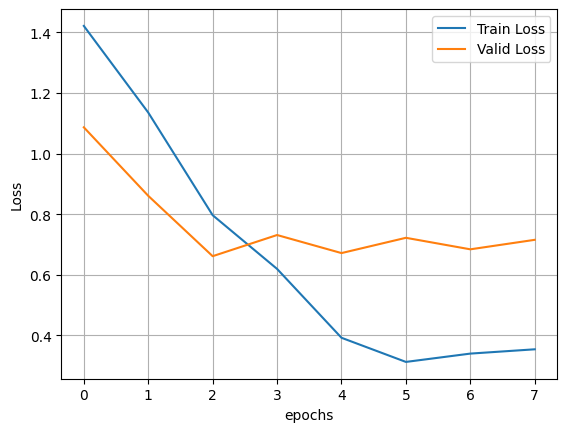

In [ ]:
plt.plot( range(history.shape[0]), history["Train Loss"].values, label="Train Loss")
plt.plot( range(history.shape[0]), history["Valid Loss"].values, label="Valid Loss")
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.grid()
plt.legend()
plt.savefig("loss_plot.png")
plt.show()

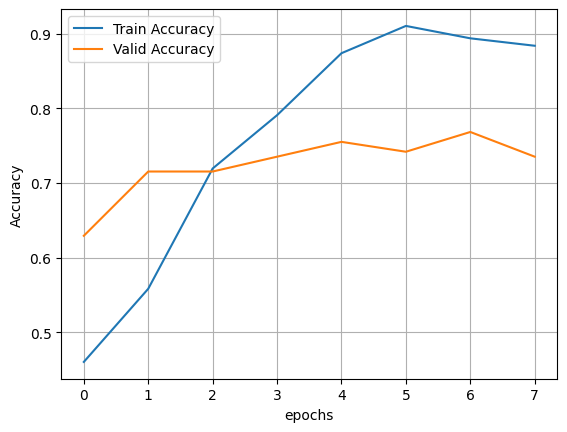

In [ ]:
plt.plot( range(history.shape[0]), history["Train Accuracy"].values, label="Train Accuracy")
plt.plot( range(history.shape[0]), history["Valid Accuracy"].values, label="Valid Accuracy")
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.grid()
plt.legend()
plt.savefig("accuracy_plot.png")
plt.show()

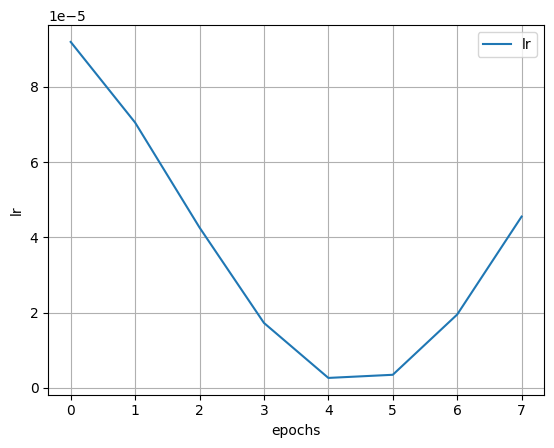

In [ ]:
plt.plot( range(history.shape[0]), history["lr"].values, label="lr")
plt.xlabel("epochs")
plt.ylabel("lr")
plt.grid()
plt.legend()
plt.savefig("lr_plot.png")
plt.show()